# Phase 1 — Inference–Validation Cycle

Use the cells below to configure models, servers, and run parameters via Pydantic models (`ModelPreset`, `ServerConfig`, `RunParams`, `InferenceValidationRun`).

- Ensure two MLNodes are running and reachable (`ip`, `node_port`, `inference_port`).
- Add one or more `InferenceValidationRun` instances to the `runs` list.
- Run the deployment and execution cell to produce JSONL outputs (paths are logged).


In [2]:
import sys
sys.path.append('../src')
sys.path.append('../../common/src')
from validation.runner import run_validation
from validation.prompts import get_alpaca_data_questions
from validation.data import (
    ModelInfo,
    RequestParams,
    save_to_jsonl,
    ModelPreset,
    ServerConfig,
    RunParams,
    InferenceValidationRun,
)
import requests
from time import sleep 
from transformers import AutoTokenizer
import os
import copy
from concurrent.futures import ThreadPoolExecutor

In [3]:
run_params_low_temp = RunParams(
    exp_name='notebook_test',
    output_path='../data/inference_results',
    batch_size=500,
    n_prompts=1000,
    timeout=600,
    tokenizer_model_name='unsloth/llama-3-8b-Instruct',
    request=RequestParams(
        max_tokens=3000,
        temperature=0.7,
        seed=42,
        top_logprobs=4,
    ),
)

run_params_high_temp = copy.deepcopy(run_params_low_temp)
run_params_high_temp.request.temperature = 0.99

(run_params_high_temp.request.temperature, run_params_low_temp.request.temperature)

(0.99, 0.7)

In [4]:
# models:
#   qwen3_235B_fp8:
#     model: "Qwen/Qwen3-235B-A22B-Instruct-2507-FP8"
#     precision: "fp8"
#     dtype: "float16"
#     additional_args: ["--max_model_len", "10000", "--enable-expert-parallel", "--tensor-parallel-size", "4", "--pipeline-parallel-size", "1"]
#   qwen3_235B_int4:
#     model: "chriswritescode/Qwen3-235B-A22B-Instruct-2507-INT4-W4A16"
#     precision: "int4"
#     dtype: "float16"
#     additional_args: ["--max_model_len", "10000", "--enable-expert-parallel", "--tensor-parallel-size", "4", "--pipeline-parallel-size", "1"]
#   qwen25_7B_fp8:
#     model: "RedHatAI/Qwen2.5-7B-Instruct-quantized.w8a16"
#     precision: "fp8"
#     dtype: "float16"
#     additional_args: []
#   qwen25_7B_fp8_tp:
#     model: "RedHatAI/Qwen2.5-7B-Instruct-quantized.w8a16"
#     precision: "fp8"
#     dtype: "float16"
#     additional_args: ["--tensor-parallel-size", "1", "--pipeline-parallel-size", "1"]
#   qwen25_7B_int4:
#     model: "Qwen/Qwen2.5-7B-Instruct-AWQ"
#     precision: "int4"
#     dtype: "float16"
#     additional_args: []
#   qwen3_32B_fp8:
#     model: "Qwen/Qwen3-32B-FP8"
#     precision: "fp8"
#     dtype: "float16"
#     additional_args: ["--max_model_len", "10000"]
#   qwen3_32B_fp8_tp:
#     model: "Qwen/Qwen3-32B-FP8"
#     precision: "fp8"
#     dtype: "float16"
#     additional_args: ["--tensor-parallel-size", "4", "--pipeline-parallel-size", "1", "--max_model_len", "10000"]
#   qwen3_32B_int4:
#     model: "RedHatAI/Qwen3-32B-quantized.w4a16"
#     precision: "int4"
#     dtype: "float16"
#     additional_args: ["--max_model_len", "10000"]

In [5]:
qwen3_32B_int4 = ModelPreset(
    model='RedHatAI/Qwen3-32B-quantized.w4a16',
    precision='int4',
    dtype='float16',
    additional_args=['--max_model_len', '10000', '--enable-auto-tool-choice', '--tool-call-parser', 'hermes'],
)

qwen3_32B_fp8 = ModelPreset(
    model='Qwen/Qwen3-32B-FP8',
    precision='fp8',
    dtype='float16',
    additional_args=['--max_model_len', '10000', '--enable-auto-tool-choice', '--tool-call-parser', 'hermes'],
)

qwen3_32B_fp8_tp = ModelPreset(
    model='Qwen/Qwen3-32B-FP8',
    precision='fp8',
    dtype='float16',
    additional_args=['--max_model_len', '10000', "--tensor-parallel-size", "4", "--pipeline-parallel-size", "1", '--enable-auto-tool-choice', '--tool-call-parser', 'hermes'],
)


In [6]:
server_1xH100 = ServerConfig(
    ip='80.188.223.202',
    node_port='19763',
    inference_port='19934',
    gpu='1xH100',
)

server_1xH100_2 = ServerConfig(
    ip='115.124.123.238',
    node_port='27177',
    inference_port='24228',
    gpu='1xH100',
)

server_8x3090 = ServerConfig(
    ip='24.124.32.70',
    node_port='49495',
    inference_port='49509',
    gpu='1xH100',
)

In [9]:
honest_qwen3_32B_run = InferenceValidationRun(
    model_inference=qwen3_32B_fp8_tp,
    model_validation=qwen3_32B_fp8,
    server_inference=server_8x3090,
    server_validation=server_1xH100,
    run_inference=run_params_high_temp,
    run_validation=run_params_high_temp,
)

fraud_qwen3_32B_run = InferenceValidationRun(
    model_inference=qwen3_32B_int4,
    model_validation=qwen3_32B_fp8,
    server_inference=server_1xH100,
    server_validation=server_1xH100_2,
    run_inference=run_params_low_temp,
    run_validation=run_params_low_temp,
)

# Populate runs list; add more runs as needed
runs = [
    # honest_qwen3_32B_run,
    fraud_qwen3_32B_run
]

In [ ]:
# Inference-validation cycle is done on the first n_prompts prompts of the dataset.
for cfg in runs:
    prompts = get_alpaca_data_questions()
    tokenizer_model_name = cfg.run_inference.tokenizer_model_name
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_model_name)

    os.makedirs(cfg.run_inference.output_path, exist_ok=True)

    def post_up(server: ServerConfig, payload):
        response = requests.post(server.up_url(), json=payload, timeout=cfg.run_inference.timeout)
        response.raise_for_status()
        return server, response

    # Prepare deployment payloads
    inference_payload = cfg.model_inference.to_deploy_payload()
    validation_payload = cfg.model_validation.to_deploy_payload()
    up_requests = [(cfg.server_inference, inference_payload), (cfg.server_validation, validation_payload)]

    with ThreadPoolExecutor(max_workers=len(up_requests)) as executor:
        futures = [executor.submit(post_up, srv, payload) for srv, payload in up_requests]
        for future in futures:
            server, response = future.result()
            print(response.status_code)
            print(response.text)

    sleep(20)

    # Build model metadata
    inference_model_info = ModelInfo(
        url=cfg.server_inference.inference_url(),
        name=cfg.model_inference.model,
        deploy_params={
            "GPU": cfg.server_inference.gpu,
            "precision": cfg.model_inference.precision,
        },
    )

    validation_model_info = ModelInfo(
        url=cfg.server_validation.inference_url(),
        name=cfg.model_validation.model,
        deploy_params={
            "GPU": cfg.server_validation.gpu,
            "precision": cfg.model_validation.precision,
        },
    )

    request_params = cfg.run_inference.request

    setting_name = cfg.setting_filename()
    DATA_PATH = f"{cfg.run_inference.output_path}/{setting_name}"

    batch_size = cfg.run_inference.batch_size
    n_prompts = cfg.run_inference.n_prompts

    for start_idx in range(0, len(prompts[:n_prompts]), batch_size):
        prompt_batch = prompts[start_idx:start_idx + batch_size]
        results_batch = run_validation(
            prompt_batch,
            inference_model=inference_model_info,
            validation_model=validation_model_info,
            request_params=request_params,
            max_workers=50,
        )
        save_to_jsonl(results_batch, DATA_PATH, append=False)
        print(f"Processed {min(start_idx + batch_size, len(prompts[:n_prompts]))} / {len(prompts[:n_prompts])} -> {DATA_PATH}")

    print(f"Completed run. Results saved to: {DATA_PATH}")

200
{"status":"OK"}
200
{"status":"OK"}


# Phase 2 — Analysis and Threshold Estimation

Use the cells below to load the generated JSONL files and estimate thresholds.

- Populate `DATA_PATHS` with paths from Phase 1 outputs.
- Define `comparisons` with one honest JSONL and one fraud JSONL per model.
- Run analysis cells to compute distances, plot distributions, and search the optimal bounds.


In [ ]:
DATA_PATHS = {
        'honest_qwen2.5_7': '../data/inference_results/Qwen2.5-7B-Instruct-quantized.w8a16-fp8-1xH100___Qwen2.5-7B-Instruct-quantized.w8a16-fp8-4x3090__script_test.jsonl',
        'fraud_qwen2.5_7': '../data/inference_results/Qwen2.5-7B-Instruct-AWQ-int4-1xH100___Qwen2.5-7B-Instruct-quantized.w8a16-fp8-1xH100__script_test.jsonl',
}

comparisons = [
    ('qwen2.5-7',
     {
        'honest': DATA_PATHS['honest_qwen2.5_7'],
        'fraud': DATA_PATHS['fraud_qwen2.5_7']
     }
    )
]

In [12]:
import sys
sys.path.append('../src')
sys.path.append('../../common/src')

import numpy as np
from validation.data import (
    load_from_jsonl,
)

from validation.analysis import analyze, process_data, plot_distances_and_matches, plot_classification_results, find_optimal_bounds_parallel, evaluate_bound, classify_data
from validation.utils import distance, token_distance2, distance2
from validation import stats
import matplotlib.pyplot as plt

Below are graphs:
- Distance depending on the number of tokens
- Percentage of top-k matches for inference and validation.

For each inference-validation cycle (2 setups: honest and fraudulent inference) we can observe this distributions to build an intuition how the distance function works.




################################################################################
Analyzing honest_qwen2.5_7 : ../data/inference_results/Qwen2.5-7B-Instruct-quantized.w8a16-fp8-1xH100___Qwen2.5-7B-Instruct-quantized.w8a16-fp8-4x3090__script_test.jsonl
Dropped 0 / 500 items


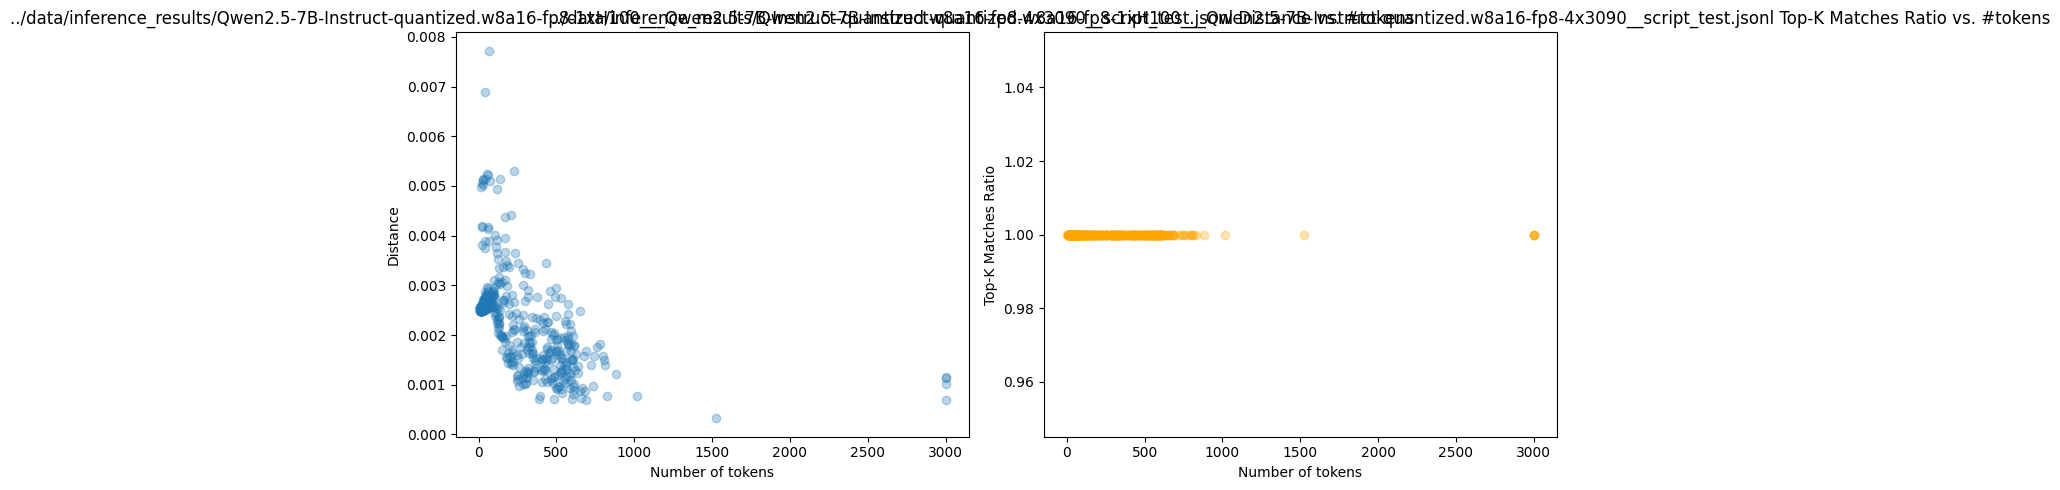




################################################################################
Analyzing fraud_qwen2.5_7 : ../data/inference_results/Qwen2.5-7B-Instruct-AWQ-int4-1xH100___Qwen2.5-7B-Instruct-quantized.w8a16-fp8-1xH100__script_test.jsonl
Dropped 0 / 500 items


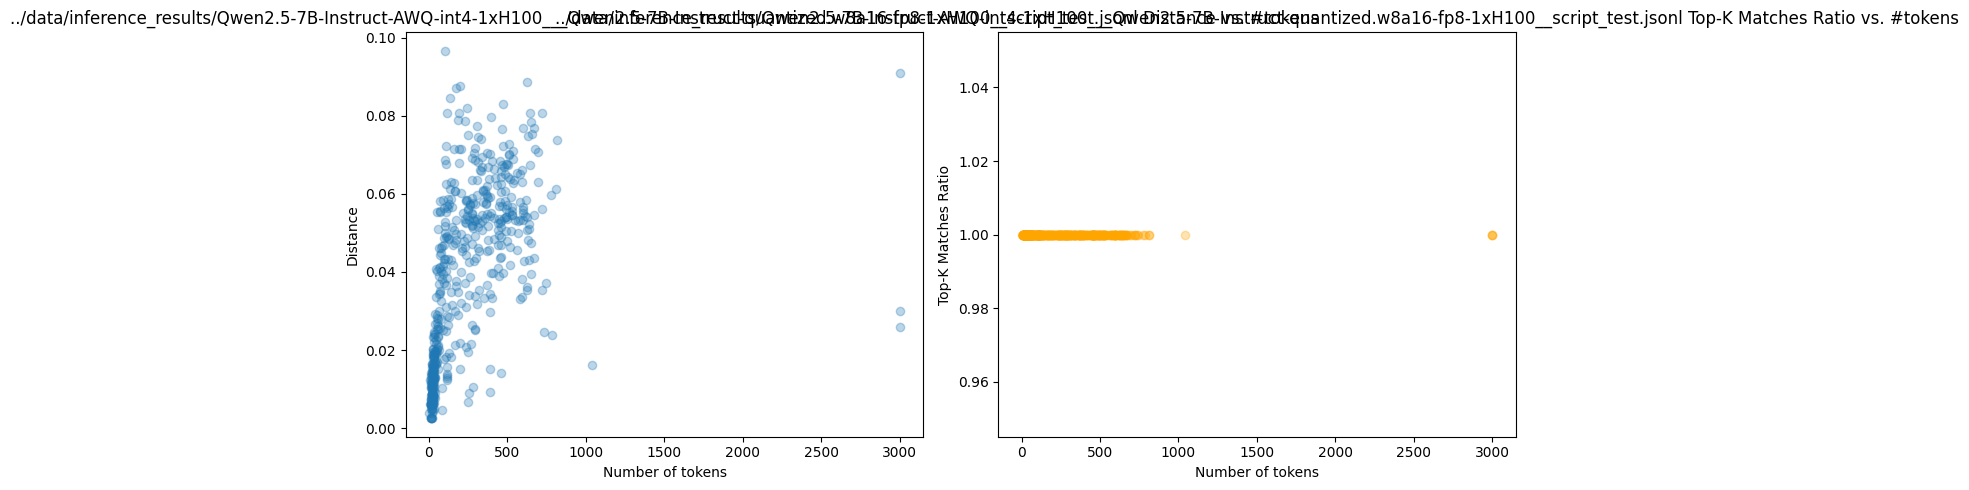

In [13]:
data_path_to_fit = {}
data_path_to_distances = {}

for name, data_path in DATA_PATHS.items():
    print("\n\n")
    print(80*"#")
    print(f"Analyzing {name} : {data_path}")
    items = load_from_jsonl(data_path, n=100000)
    items, distances, top_k_matches_ratios = process_data(items)
    plot_distances_and_matches(items, distances, top_k_matches_ratios, data_path)
    data_path_to_distances[data_path] = distances

Below are illustrations of classification using the found estimations for the best distance threshold.

There is a pair of graphs, each pair consists of honest inference-validation (in FP8) and fraudulent (quantized INT4) inference + honest (fp8) validation.

- Full classification counts is just a bar chart of the number of TP for detecting honest inference.
- Full distances classification is illustration of how far typical distances are related to the threshold.
- Quant classification counts shows classification results for the fraudulent inference.
- Quant distances classification shows how distance thresholds relates to the typical distance range for the fraudulent inference.

For each model we have these 4 graphs that depict how well can we distinguish honest and quantized inference using the distance threshold.

qwen2.5-7


Searching optimal bounds: 100%|████████████████| 97/97 [00:00<00:00, 780.88it/s]


Optimal Lower Bound: 0.008324
Optimal Upper Bound: 0.009324
Best F1-Score: 0.9551


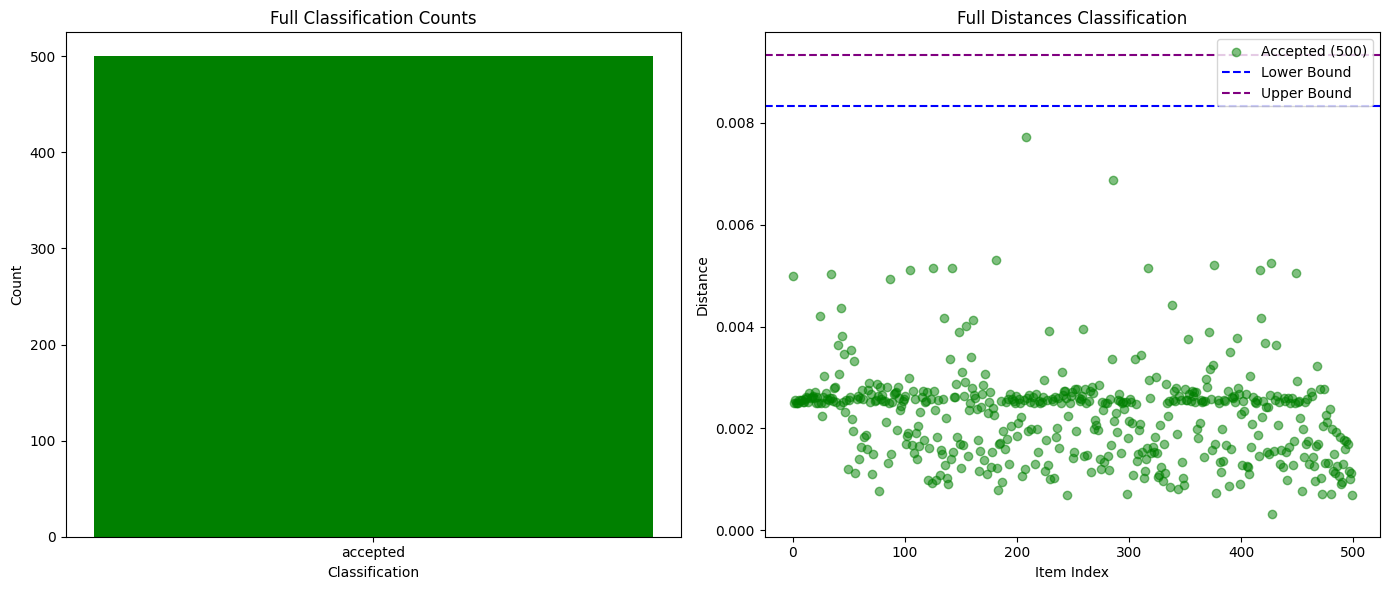

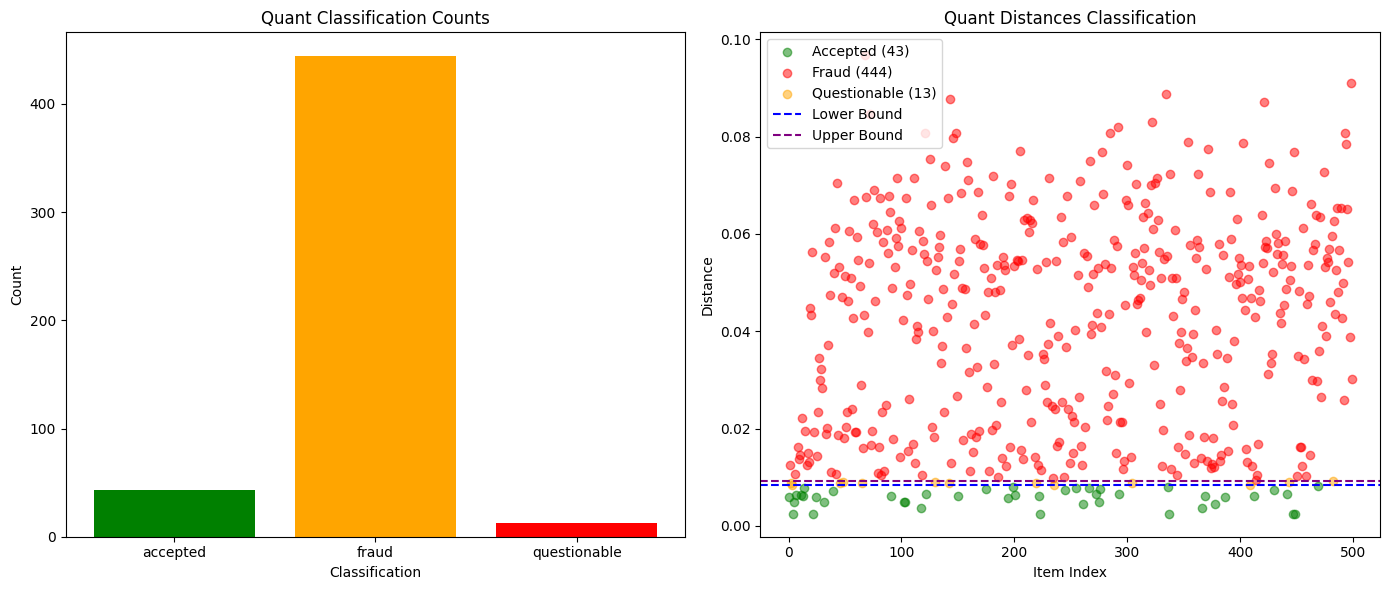

In [14]:
for name, comparison in comparisons:
    print('='*80)
    print(name)
    
    distances_honest = data_path_to_distances[comparison['honest']]
    distances_fraud = data_path_to_distances[comparison['fraud']]
    
    optimal_lower, optimal_upper = find_optimal_bounds_parallel(distances_honest, distances_fraud, n_jobs=64, step=0.001)
    
    classifications_full = classify_data(distances_honest, optimal_lower, optimal_upper)
    classifications_fraud = classify_data(distances_fraud, optimal_lower, optimal_upper)
    
    plot_classification_results(
        distances_honest, classifications_full, optimal_lower, optimal_upper, title_prefix="Full"
    )
    plot_classification_results(
        distances_fraud, classifications_fraud, optimal_lower, optimal_upper, title_prefix="Quant"
    )